In [3]:
#Ref - https://towardsdatascience.com/building-a-logistic-regression-in-python-step-by-step-becd4d56c9c8
import pandas as pd
import numpy as np
import datetime
import talib as ta
import matplotlib.pyplot as plt
import seaborn as sns
import talib as ta
import warnings
warnings.filterwarnings('ignore')

In [4]:
#Read data
data = pd.read_csv('data/analysis/D1_XAUUSD_Returns.csv', parse_dates=[0], index_col='Date')
#print(data.head())

In [5]:
#Date related features
data['Week'] = data.index.week
data['Day_Week'] = data.index.dayofweek
data['daily_return'] = data.Close.pct_change().mul(100)
data['day_week_sin'] = np.sin(data.Day_Week*(2.*np.pi/7))
data['day_week_cos'] = np.cos(data.Day_Week*(2.*np.pi/7))
data['week_sin'] = np.sin((data.Week-1)*(2.*np.pi/52))
data['week_cos'] = np.cos((data.Week-1)*(2.*np.pi/52))
data['yearday_sin'] = np.sin((data.Yearday)*(2.*np.pi/365.25))
data['yearday_cos'] = np.cos((data.Yearday)*(2.*np.pi/365.25))
#Simple Moving Average - 50 day
data['SMA_50'] = ta.SMA(data.Close, timeperiod = 50)
#Simple Moving Average - 200 day
data['SMA_200'] = ta.SMA(data.Close, timeperiod = 200)
# Exponential Moving Average - 9 day
data['EMA_9'] = ta.EMA(data.Close, timeperiod = 9)
# Exponential Moving Average - 21 day
data['EMA_21'] = ta.EMA(data.Close, timeperiod = 21)
# MACD
data['macd'], data['macdsignal'], data['macdhist'] = ta.MACD(data.Close, fastperiod=12, slowperiod=200, signalperiod=9)
# RSI
data['RSI'] = ta.RSI(data.Close, timeperiod=14)
#Define relative indicators
data['SMA_Delta'] = (data['SMA_50'] - data['SMA_200']) / data['Close']
#Define relative indicators
data['EMA_Delta'] = (data['EMA_9'] - data['EMA_21']) / data['Close']

In [6]:
print(data.tail())

               Open     High      Low    Close  Volume   Weekday  Yearday  \
Date                                                                        
2019-04-25  1274.63  1282.53  1273.31  1278.56   97134  Thursday      115   
2019-04-26  1278.56  1288.61  1273.72  1285.69  107326    Friday      116   
2019-04-28  1286.28  1286.62  1285.63  1285.80    1913    Sunday      118   
2019-04-29  1285.79  1286.57  1277.99  1280.33   80222    Monday      119   
2019-04-30  1280.32  1286.12  1279.84  1283.11  103615   Tuesday      120   

            Daily_return  Log_daily_Return  Week  ...     SMA_50     SMA_200  \
Date                                              ...                          
2019-04-25      0.308325          0.003079    17  ...  1295.9396  1260.27820   
2019-04-26      0.557659          0.005561    17  ...  1295.0698  1260.74670   
2019-04-28      0.008556          0.000086    17  ...  1294.3640  1261.19035   
2019-04-29     -0.425416         -0.004263    18  ...  1293.

In [7]:
#Choosing target variable
data['Large_return'] = np.where(data['daily_return']>=0.1, 1, 0)

In [8]:
#Drop rows with nan values
data.dropna(inplace=True)

In [9]:
#Pick features
features_list = ['Volume','day_week_sin','day_week_cos','week_sin','week_cos','yearday_sin','yearday_cos',
                 'macdhist', 'RSI', 'SMA_Delta','EMA_Delta']
features = data[features_list]
features.head()

,Volume,day_week_sin,day_week_cos,week_sin,week_cos,yearday_sin,yearday_cos,macdhist,RSI,SMA_Delta,EMA_Delta
Date,,,,,,,,,,,
2004-01-12,20736,0.000000,1.000000,0.239316,0.970942,0.204966,0.978769,2.239954,70.847411,0.071611,0.011534
2004-01-13,21473,0.781831,0.623490,0.239316,0.970942,0.221772,0.975099,1.835514,68.227339,0.072198,0.010996
2004-01-14,20415,0.974928,-0.222521,0.239316,0.970942,0.238513,0.971139,0.945729,57.107955,0.073547,0.009352
2004-01-15,22449,0.433884,-0.900969,0.239316,0.970942,0.255182,0.966893,-0.982156,39.857679,0.075568,0.005214
2004-01-16,19571,-0.433884,-0.900969,0.239316,0.970942,0.271777,0.962360,-2.539018,37.444023,0.076086,0.001362


In [10]:
#Pick target variable 
target_unshifted = data['Large_return']
#Add shift so we can predict target on time t=1 with features from time t
target = target_unshifted.shift(-1)
#Drop last value from features and target (Nan)
features = features[:-1]
target = target[:-1]
print(features.tail())
print(target.tail())

            Volume  day_week_sin  day_week_cos  week_sin  week_cos  \
Date                                                                 
2019-04-24   97655      0.974928     -0.222521  0.935016 -0.354605   
2019-04-25   97134      0.433884     -0.900969  0.935016 -0.354605   
2019-04-26  107326     -0.433884     -0.900969  0.935016 -0.354605   
2019-04-28    1913     -0.781831      0.623490  0.935016 -0.354605   
2019-04-29   80222      0.000000      1.000000  0.885456 -0.464723   

            yearday_sin  yearday_cos  macdhist        RSI  SMA_Delta  \
Date                                                                   
2019-04-24     0.924803    -0.380447 -6.111534  36.796126   0.029050   
2019-04-25     0.918121    -0.396299 -5.161771  41.209393   0.027892   
2019-04-26     0.911169    -0.412034 -3.540636  48.267119   0.026696   
2019-04-28     0.896456    -0.443132 -2.331190  48.370097   0.025800   
2019-04-29     0.888701    -0.458487 -2.080020  43.710538   0.025073   

    

In [11]:
target.value_counts()

0.0    2607
1.0    2164
Name: Large_return, dtype: int64

In [12]:
def split_train_test(data, train_ratio):
    indices = np.arange(len(data))
    train_set_size = int(len(data) * train_ratio)
    train_indices = indices[:train_set_size]
    test_indices = indices[train_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

X_train_set, X_test_set = split_train_test(features, 0.8)

In [13]:
print(len(X_train_set))
print(len(X_test_set))
print("Training Series:", "\n", X_train_set.head(), "\n")
print("Training Series:", "\n", X_train_set.tail(), "\n")
print("Testing Series:", "\n", X_test_set.head())
print("Testing Series:", "\n", X_test_set.tail())

3816
955
Training Series: 
             Volume  day_week_sin  day_week_cos  week_sin  week_cos  \
Date                                                                 
2004-01-12   20736      0.000000      1.000000  0.239316  0.970942   
2004-01-13   21473      0.781831      0.623490  0.239316  0.970942   
2004-01-14   20415      0.974928     -0.222521  0.239316  0.970942   
2004-01-15   22449      0.433884     -0.900969  0.239316  0.970942   
2004-01-16   19571     -0.433884     -0.900969  0.239316  0.970942   

            yearday_sin  yearday_cos  macdhist        RSI  SMA_Delta  \
Date                                                                   
2004-01-12     0.204966     0.978769  2.239954  70.847411   0.071611   
2004-01-13     0.221772     0.975099  1.835514  68.227339   0.072198   
2004-01-14     0.238513     0.971139  0.945729  57.107955   0.073547   
2004-01-15     0.255182     0.966893 -0.982156  39.857679   0.075568   
2004-01-16     0.271777     0.962360 -2.539018  3

In [14]:
y_train_set, y_test_set = split_train_test(target, 0.8)

In [15]:
print(len(y_train_set))
print(len(y_test_set))
print("Training Series:", "\n", y_train_set.head(), "\n")
print("Training Series:", "\n", y_train_set.tail(), "\n")
print("Testing Series:", "\n", y_test_set.head())
print("Testing Series:", "\n", y_test_set.tail())

3816
955
Training Series: 
 Date
2004-01-12    0.0
2004-01-13    0.0
2004-01-14    0.0
2004-01-15    0.0
2004-01-16    0.0
Name: Large_return, dtype: float64 

Training Series: 
 Date
2016-03-28    1.0
2016-03-29    0.0
2016-03-30    1.0
2016-03-31    0.0
2016-04-01    0.0
Name: Large_return, dtype: float64 

Testing Series: 
 Date
2016-04-03    0.0
2016-04-04    1.0
2016-04-05    0.0
2016-04-06    1.0
2016-04-07    0.0
Name: Large_return, dtype: float64
Testing Series: 
 Date
2019-04-24    1.0
2019-04-25    1.0
2019-04-26    0.0
2019-04-28    0.0
2019-04-29    1.0
Name: Large_return, dtype: float64


In [16]:
#SMOTE to balance data
from imblearn.over_sampling import SMOTE
os = SMOTE(random_state=0)

columns = X_train_set.columns

os_data_X,os_data_y=os.fit_sample(X_train_set, y_train_set.values.ravel())
os_data_X = pd.DataFrame(data=os_data_X,columns=columns )
os_data_y= pd.DataFrame(data=os_data_y,columns=['y'])
# we can Check the numbers of our data
print("length of oversampled data is ",len(os_data_X))
print("Number of no subscription in oversampled data",len(os_data_y[os_data_y['y']==0]))
print("Number of positive returns",len(os_data_y[os_data_y['y']==1]))
print("Proportion of pos. returns data in oversampled data is ",len(os_data_y[os_data_y['y']==0])/len(os_data_X))
print("Proportion of pos. returns data in oversampled data is ",len(os_data_y[os_data_y['y']==1])/len(os_data_X))

length of oversampled data is  4152
Number of no subscription in oversampled data 2076
Number of positive returns 2076
Proportion of pos. returns data in oversampled data is  0.5
Proportion of pos. returns data in oversampled data is  0.5


In [17]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
rfe = RFE(logreg, 12)
rfe = rfe.fit(os_data_X, os_data_y.values.ravel())
print(rfe.support_)
print(rfe.ranking_)

[ True  True  True  True  True  True  True  True  True  True  True]
[1 1 1 1 1 1 1 1 1 1 1]


In [18]:
#Use SMOTE data

X_train_set, X_test_set = split_train_test(os_data_X, 0.8)
y_train_set, y_test_set = split_train_test(os_data_y, 0.8)

In [19]:
print(len(X_train_set))
print(len(X_test_set))
print("Training Series:", "\n", X_train_set.head(), "\n")
print("Training Series:", "\n", X_train_set.tail(), "\n")
print("Testing Series:", "\n", X_test_set.head())
print("Testing Series:", "\n", X_test_set.tail())

3321
831
Training Series: 
     Volume  day_week_sin  day_week_cos  week_sin  week_cos  yearday_sin  \
0  20736.0      0.000000      1.000000  0.239316  0.970942     0.204966   
1  21473.0      0.781831      0.623490  0.239316  0.970942     0.221772   
2  20415.0      0.974928     -0.222521  0.239316  0.970942     0.238513   
3  22449.0      0.433884     -0.900969  0.239316  0.970942     0.255182   
4  19571.0     -0.433884     -0.900969  0.239316  0.970942     0.271777   

   yearday_cos  macdhist        RSI  SMA_Delta  EMA_Delta  
0     0.978769  2.239954  70.847411   0.071611   0.011534  
1     0.975099  1.835514  68.227339   0.072198   0.010996  
2     0.971139  0.945729  57.107955   0.073547   0.009352  
3     0.966893 -0.982156  39.857679   0.075568   0.005214  
4     0.962360 -2.539018  37.444023   0.076086   0.001362   

Training Series: 
        Volume  day_week_sin  day_week_cos  week_sin  week_cos  yearday_sin  \
3316  60928.0     -0.433884     -0.900969 -0.748511 -0.663123 

In [20]:
print(len(y_train_set))
print(len(y_test_set))
print("Training Series:", "\n", y_train_set.head(), "\n")
print("Training Series:", "\n", y_train_set.tail(), "\n")
print("Testing Series:", "\n", y_test_set.head())
print("Testing Series:", "\n", y_test_set.tail())

3321
831
Training Series: 
      y
0  0.0
1  0.0
2  0.0
3  0.0
4  0.0 

Training Series: 
         y
3316  0.0
3317  1.0
3318  1.0
3319  1.0
3320  0.0 

Testing Series: 
         y
3321  0.0
3322  0.0
3323  0.0
3324  1.0
3325  0.0
Testing Series: 
         y
4147  1.0
4148  1.0
4149  1.0
4150  1.0
4151  1.0


In [23]:
#Datacamp example
from sklearn.model_selection import GridSearchCV

# Setup the hyperparameter grid
c_space = np.logspace(-5, 8, 15)
param_grid = {'C': c_space}

logreg_cv = GridSearchCV(logreg, param_grid, cv=5)

#model = LogisticRegression(solver='lbfgs', max_iter=100) 
logreg_cv.fit(X_train_set, y_train_set.values.ravel())

# Print the tuned parameters and score
print("Tuned Logistic Regression Parameters: {}".format(logreg_cv.best_params_)) 
print("Best score is {}".format(logreg_cv.best_score_))


y_model = logreg_cv.predict(X_test_set)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg_cv.score(X_test_set, y_test_set)))

Tuned Logistic Regression Parameters: {'C': 268.2695795279727}
Best score is 0.5408009635651913
Accuracy of logistic regression classifier on test set: 0.36


In [25]:
from sklearn import metrics
print(metrics.classification_report(y_test_set, y_model))

              precision    recall  f1-score   support

         0.0       0.36      1.00      0.53       301
         1.0       0.00      0.00      0.00       530

   micro avg       0.36      0.36      0.36       831
   macro avg       0.18      0.50      0.27       831
weighted avg       0.13      0.36      0.19       831



[[301   0]
 [530   0]]


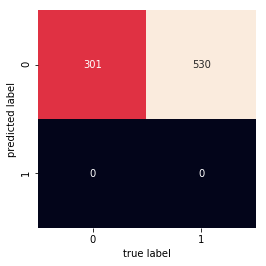

In [24]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(y_test_set, y_model)
print(mat)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');